In [116]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt

In [117]:
TFtot = 2000
kon = 0.0016399 
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p =  kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled = kmax * kdegR / (kbasal + kmax)
kbasal_scaled = kbasal * kdegR / (kbasal + kmax)

k_alpha = kon * 1000 / koff
k_beta = koff 

p_scaled = k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR

print(Kd_scaled, kmax_scaled, kbasal_scaled)

0.478375 0.04203519639903277 8.080360096723108e-05


In [118]:
def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol


    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step), tol=1e-9)

    steady = np.maximum(sol.x,[0,0])
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    steady = np.trapz(sol.y, x=sol.t) / period

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p):

    # Parameters
    commonPars, ampPars, invertPars = p
    kdegR, kdegPPDC, Ks, Y, KI_PDC, nI_PDC = commonPars
    mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp = ampPars
    mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert = invertPars

    x_guess = x
    global setpoint

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x
    S = np.max(S,0)
    Enz_invert = np.max((Enz_invert,0))
    Enz_amp = np.max((Enz_amp,0))
    Rep = np.max((Rep,0))
    Amp = np.max((Amp,0))

    mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) #* ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert ** nI_PDC + 1e-10))
    mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) #* ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp ** nI_PDC + 1e-10))

    dmRNA_invert_dt = (setpoint[1] - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (setpoint[1] - mRNA_amp) / tau_mRNA

    
    dRepdt = k_trans_Rep * mRNA_invert * S / (Ks + S) - (kdeg_Rep + mu_x_invert) * Rep
    dEnz_invert_dt = k_trans_PDC_invert * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert

    
    dAmpdt = k_trans_Amp * mRNA_amp * S / (Ks + S) - (kdeg_Amp + mu_x_amp) * Amp
    dEnz_amp_optodt = k_trans_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp

    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp
    dX_invert_dt = mu_x_invert * X_invert
    dX_amp_dt = mu_x_amp * X_amp

    # names = ['mRNA_invert', 'mRNA_amp', 'Rep', 'Amp', 'Enz_invert', 'Enz_amp', 'S', 'X_invert', 'X_amp']
    # for var, name in zip([mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp], names):
    #     if var<0:
    #         print('BIOOPY', name)
    #         assert False



    return [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt]


In [119]:
from tqdm import tqdm
from scipy.interpolate import interp1d

run = False
if run:
    u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,100))))

    # u_arr = np.flip(10 ** np.linspace(-1,0,100))
    Enz_arr = np.zeros(u_arr.size)
    mRNA_arr = np.zeros(u_arr.size)

    setpoint = None
    for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
        # print(u)
        period = 100 / 60
        Imax = 1
        setpoint = steady_mRNA_solve(u, period, Imax, x_guess=setpoint)
        # print(setpoint)
        mRNAss = setpoint[1]
        mRNA_arr[i] = mRNAss

mRNA_fun = interp1d(u_arr, mRNA_arr, kind='cubic')


In [120]:
# assert False

# Common Parameters
kdegR = 0.042116
# kdegP = 12 / np.log(2) * 60
kdegPPDC = 12 / np.log(2) * 60
Ks = 1
Y = 0.5
nI_PDC = 1
KI_PDC = 1000
commonPars = kdegR, kdegPPDC, Ks, Y, KI_PDC, nI_PDC

# Invert Parameters
kdeg_Rep = 12 / np.log(2) * 60
K_Rep = 0.1
n_Rep = 1
mu_max_invert = 0.8
k_trans_Rep = (mu_max_invert + kdeg_Rep) * 5
k_trans_PDC_invert = (mu_max_invert + kdegPPDC)
invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert

# Amp Parameters
kdeg_Amp = 12 / np.log(2) * 60
K_Amp = 0.15
mu_max_amp = 1.
n_Amp = 0.9
k_trans_Amp = mu_max_amp + kdeg_Amp
k_trans_PDC_amp = (mu_max_amp + kdegPPDC) * 1
ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp

p = commonPars, ampPars, invertPars



steady_state = []
for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
    # print(u)
    global setpoint
    setpoint = [0, mRNA_arr[i]]
    def rootfunc(x):
        S = 2
        X_invert = 0.01
        X_amp = 0.01
        mRNA_invert = mRNA_arr[i]
        mRNA_amp = mRNA_arr[i]
        Rep, Amp, Enz_invert, Enz_amp = x
        x_in = mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
        return opto_growth(0,x_in,p)[2:-3]
    output = root(rootfunc, [1, 1, 1, 1], tol=1e-10, method='hybr')
    steady_state.append(output.x)
    # if output.success is False:
        # print(u, output.message)
steady_state = np.array(steady_state)

100%|██████████| 101/101 [00:00<00:00, 2384.51it/s]


In [121]:
Rep_ss, Amp_ss, Enz_invert_ss, Enz_amp_ss = steady_state.T
mu_amp = mu_max_amp * Enz_amp_ss * 2 / (Ks + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
mu_invert = mu_max_invert * Enz_invert_ss * 2 / (Ks + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

In [122]:
amp_data = np.array([0.120837503, 0.123422835, 0.180854158, 0.19976335, 0.212471916, 0.262908006, 0.265834766, 0.308231875, 0.300134524, 0.307690564, 0.349198597, 0.235627624, 0.328256455, 0.256070133, 0.271335288, 0.18874746, 0.170414488, 0.133141302])
amp_lights = np.array([1, 1, 3, 3, 6, 6, 8, 8, 10, 10, 10, 20, 20, 40, 40, 70, 70, 100]) / 100

invert_data = np.array([0.259118174, 0.249223514, 0.251594487, 0.163109986, 0.116035613, 0.071939681, 0.064949075, 0.089238774, 0.08784264, 1E-10, 0.0414111, 0.040288699, 0.033536204])
invert_lights = np. array([0, 0, 1, 1.667, 1.667, 5, 5, 5, 5, 100, 100, 100, 100])/100

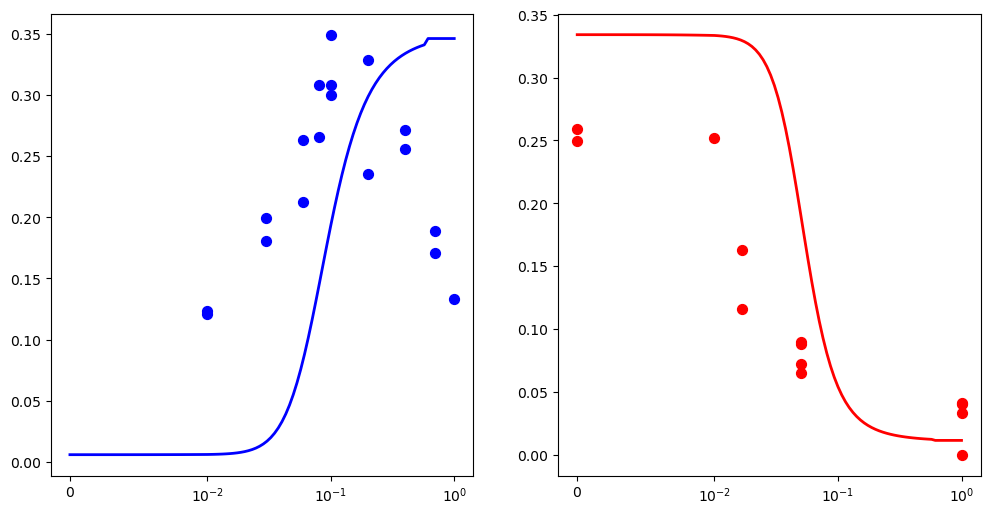

In [123]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_amp, label='Amp', color='blue', linewidth=2)
ax.scatter(amp_lights, amp_data, color='blue', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, mu_invert, label='Invert', color='red', linewidth=2)
ax.scatter(invert_lights, invert_data, color='red', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

In [124]:
k_trans_Amp / kdeg_Amp

1.0009627044174443

In [132]:
def makessDoseRespCurve(p, u_arr, mRNA_fun):
    kdegPPDC = 1
    kdegR = 1
    kdeg_Rep = 1
    kdeg_Amp = 1
    Y = 0.5
    Ks = 1
    # KI_PDC = 1000
    # nI_PDC = 1
    mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp = p

    commonPars = kdegR, kdegPPDC, Ks, Y, KI_PDC, nI_PDC
    invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert
    ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp
    p_in = commonPars, ampPars, invertPars

    steady_state = []
    for i, u in enumerate(u_arr):
        global setpoint
        setpoint = [0, mRNA_fun(u)]
        def rootfunc(x):
            S = 2
            X_invert = 0.01
            X_amp = 0.01
            mRNA_invert = mRNA_fun(u)
            mRNA_amp = mRNA_fun(u)
            Rep, Amp, Enz_invert, Enz_amp = x
            x_in = mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp
            return opto_growth(0,x_in,p_in)[2:-3]
        output = root(rootfunc, [0.1, 0.1, 0.1, 0.1], tol=1e-10, method='hybr')
        if output.success is False:
            init = [mRNA_fun(u), mRNA_fun(u), 1, 1, 1, 1, 200, 0.01, 0.01]
            sol = solve_ivp(opto_growth, [0,50], init, args=(p_in, ), t_eval=[50], method='BDF', rtol=1e-6, atol=1e-9)
            # print(sol.message)
            output = root(rootfunc, sol.y[2:-3,-1])
            if output.success is False:
                # print(u, output.message)
                output = np.array([0,0,0,0])
                steady_state.append(output)
            else:
                steady_state.append(output.x)
        else:
            steady_state.append(output.x)
    steady_state = np.array(steady_state)
    return steady_state

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x

In [133]:
# Common Parameters
kdegR = 0.042116
# kdegP = 12 / np.log(2) * 60
kdegPPDC = 12 / np.log(2) * 60
Ks = 1
Y = 0.5
nI_PDC = 1
KI_PDC = 1000
commonPars = kdegR, kdegPPDC, Ks, Y, KI_PDC, nI_PDC

# Invert Parameters
kdeg_Rep = 12 / np.log(2) * 60
K_Rep = 0.1
n_Rep = 1
mu_max_invert = 0.8
k_trans_Rep = (mu_max_invert + kdeg_Rep) * 5
k_trans_PDC_invert = (mu_max_invert + kdegPPDC)
invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert

# Amp Parameters
kdeg_Amp = 12 / np.log(2) * 60
K_Amp = 0.15
mu_max_amp = 1.
n_Amp = 0.9
k_trans_Amp = mu_max_amp + kdeg_Amp
k_trans_PDC_amp = (mu_max_amp + kdegPPDC) * 1
ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp


orig_pars =  KI_PDC, nI_PDC, mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp

p_guess = mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp
bounds = (0, np.inf)
steady_state  = makessDoseRespCurve(p_guess, u_arr, mRNA_fun)

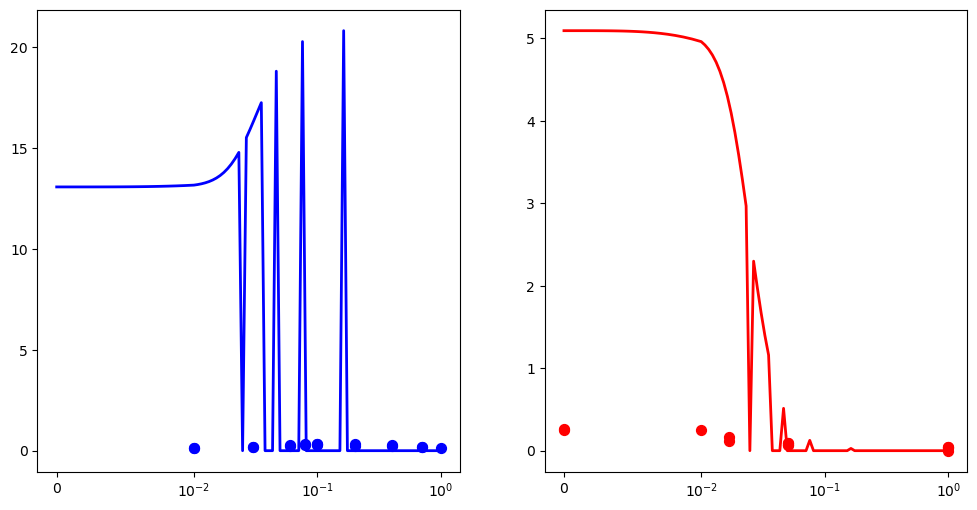

In [134]:
Rep_ss, Amp_ss, Enz_invert_ss, Enz_amp_ss = steady_state.T
mu_amp = mu_max_amp * Enz_amp_ss * 2 / (Ks + 2)# * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
mu_invert = mu_max_invert * Enz_invert_ss * 2 / (Ks + 2)# * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_amp, label='Amp', color='blue', linewidth=2)
ax.scatter(amp_lights, amp_data, color='blue', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, mu_invert, label='Invert', color='red', linewidth=2)
ax.scatter(invert_lights, invert_data, color='red', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

In [135]:
from scipy.interpolate import interp1d
from scipy.optimize import minimize

def fsolve_fun(x, u_vals, mRNA_fun, info): 
    x = 10 ** np.array(x)

    output_states = makessDoseRespCurve(x, u_vals, mRNA_fun)
    _, _, Enz_invert_ss, Enz_amp_ss = output_states.T
    KI_PDC, nI_PDC, mu_max_invert, _, _, _, _, mu_max_amp, _, _, _, _ = x
    mu_amp = mu_max_amp * Enz_amp_ss * 2 / (1 + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
    mu_invert = mu_max_invert * Enz_invert_ss * 2 / (1 + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

    amp_error = 0
    inv_error = 0
    for i, u in enumerate(u_vals):
        if any(amp_lights == u) and u < 0.11:
            amp_error += np.sqrt(np.mean((mu_amp[i] - amp_data[amp_lights == u]) ** 2))
        if any(invert_lights == u):
            inv_error += np.sqrt(np.mean((mu_invert[i] - invert_data[invert_lights == u]) ** 2))

    # error = np.sqrt(amp_error**2 + inv_error ** 2)
    error = amp_error + inv_error

    if error < info['best_error']:
        info['best_error'] = error
        info['best_pars'] = x

    if info['Nfeval']%10 == 0:
        print('Nfeval: ', info['Nfeval'], 'AmpError', amp_error, 'InvError', inv_error, 'CurrentError', error, 'BestError: ', info['best_error'])
    info['Nfeval'] += 1

    return error

In [139]:
# Common Parameters
kdegR = 0.042116
# kdegP = 12 / np.log(2) * 60
kdegPPDC = 12 / np.log(2) * 60
Ks = 1
Y = 0.5
commonPars = kdegR, kdegPPDC, Ks, Y, KI_PDC, nI_PDC

# Invert Parameters
kdeg_Rep = 12 / np.log(2) * 60
K_Rep = 0.1
n_Rep = 1
mu_max_invert = 0.8
k_trans_Rep = (mu_max_invert + kdeg_Rep) * 1 / kdeg_Rep
k_trans_PDC_invert = (mu_max_invert + kdegPPDC) / kdegPPDC
invertPars = mu_max_invert, k_trans_Rep, kdeg_Rep, K_Rep, n_Rep, k_trans_PDC_invert

# Amp Parameters
kdeg_Amp = 12 / np.log(2) * 60
K_Amp = 0.15
mu_max_amp = 1.
n_Amp = 0.9
k_trans_Amp = (mu_max_amp + kdeg_Amp) / kdeg_Amp
k_trans_PDC_amp = (mu_max_amp + kdegPPDC) * 5 / kdegPPDC
ampPars = mu_max_amp, k_trans_Amp, kdeg_Amp, K_Amp, n_Amp, k_trans_PDC_amp

u_vals = np.unique(np.concatenate((amp_lights, invert_lights)))
p_guess = np.array([mu_max_invert, k_trans_Rep, K_Rep, n_Rep, k_trans_PDC_invert, mu_max_amp, k_trans_Amp, K_Amp, n_Amp, k_trans_PDC_amp])
p_guess = np.log10(p_guess)
# bounds = ((0,10), # KI_PDC
#           (0.1,10), # nI_PDC
#           (0.1,10), # mu_max_invert
#           (0.1,10), # k_trans_Rep
#           (0.1,10), # K_Rep
#           (0.1,10), # n_Rep
#           (0.1,10), # k_trans_PDC_invert
#           (0.1,10), # mu_max_amp
#           (0.1,10), # k_trans_Amp
#           (0.1,10), # K_Amp
#           (0.1,10), # n_Amp
#           (0.1,10), # k_trans_PDC_amp
#         )
bounds = ((-1,1), # mu_max_invert
          (-1,1), # k_trans_Rep
          (-2,1), # K_Rep
          (-2,1), # n_Rep
          (-1,1), # k_trans_PDC_invert
          (-1,1), # mu_max_amp
          (-1,1), # k_trans_Amp
          (-2,1), # K_Amp
          (-2,1), # n_Amp
          (-1,1), # k_trans_PDC_amp
        )


In [140]:
import scipy.optimize

# p_guess = np.log10(info['best_pars'])
info = {'Nfeval':0, 'best_error':np.inf, 'best_pars':p_guess}

sol = minimize(fsolve_fun, p_guess, args=(u_vals,mRNA_fun,info,), method='Powell', options={'maxiter': 1000, 'maxfev': 1000}, bounds=bounds)
# sol = scipy.optimize.dual_annealing(fsolve_fun, bounds, args=(u_vals,mRNA_fun,info,), maxiter=10000, seed=0, x0=p_guess, no_local_search=False)
# sol = scipy.optimize.differential_evolution(fsolve_fun, bounds, args=(u_vals,mRNA_fun,info,), maxiter=10000, seed=0, popsize=10, tol=0.01, mutation=(0.5, 1), recombination=0.7, updating='deferred', workers=-1, polish=True, init='latinhypercube', atol=0)
# sol = scipy.optimize.basinhopping(fsolve_fun, p_guess, minimizer_kwargs={'args':(u_vals,mRNA_fun,info,), 'method':'Powell', 'bounds':bounds}, niter=1000, T=0.5, stepsize=0.1, interval=50)
print(sol.x)
print(sol.success)
print(sol.message)

ValueError: not enough values to unpack (expected 12, got 10)

In [ ]:
print(info)
# print(sol.x)

In [ ]:
# print(fsolve_fun(orig_pars, u_vals, mRNA_fun, {'Nfeval':0, 'best_error':np.inf, 'best_pars':p_guess}), orig_pars)
# print(fsolve_fun(sol.x, u_vals, mRNA_fun, {'Nfeval':0, 'best_error':np.inf, 'best_pars':p_guess}), sol.x)
print(fsolve_fun(np.log10(info['best_pars']), u_vals, mRNA_fun, {'Nfeval':0, 'best_error':np.inf, 'best_pars':p_guess}), info['best_pars'])

In [ ]:
parstouse = info['best_pars']
utouse = u_arr

output_states = makessDoseRespCurve(parstouse, utouse, mRNA_fun)
_, _, Enz_invert_ss, Enz_amp_ss = output_states.T
KI_PDC, nI_PDC, mu_max_invert, _, _, _, _, mu_max_amp, _, _, _, _ = parstouse
mu_amp = mu_max_amp * Enz_amp_ss * 2 / (1 + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_amp_ss ** nI_PDC + 1e-10))
mu_invert = mu_max_invert * Enz_invert_ss * 2 / (1 + 2) * ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(utouse, mu_amp, label='Amp', color='blue', linewidth=2)
ax.scatter(amp_lights, amp_data, color='blue', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(utouse, mu_invert, label='Invert', color='red', linewidth=2)
ax.scatter(invert_lights, invert_data, color='red', marker='o', s=50)
ax.set_xscale('symlog', linthresh=0.01)

In [ ]:
Enz_invert_ss * 2 / (1 + 2) #* ((KI_PDC ** nI_PDC) / (KI_PDC ** nI_PDC + Enz_invert_ss ** nI_PDC + 1e-10))

In [ ]:
mu_max_invert